<div style="text-align: center; color: #00008B; font-size: 22px;">

# Lighthouse - Desafio Cientista de Dados

**Autor: Gabriel Ferri**

</div>


Este notebook foi estruturado para priorizar a apresentação clara dos resultados, simplificando as funções e códigos utilizados. Todas as importações e funções essenciais estão concentradas no início do documento, permitindo ao leitor revisar detalhadamente o código e as funções documentadas. Essa organização contribui para manter a visualização dos resultados limpa e sem interferências.

Para facilitar a navegação e acessibilidade ao conteúdo, hyperlinks foram incorporados no início do documento e antes da seção de Modelagens.

# Hyperlinks

. [Importação das bibliotecas e pacotes](#Importação-das-bibliotecas-e-pacotes)

. [Definição das Funções](#Definição-das-Funções)

. [Análise Exploratória de Dados (EDA)](#Análise-Exploratória-de-Dados-(EDA))

. [Modelagens](#Modelagens)

. [Conclusão](#Conclusão)

# Importação das bibliotecas e pacotes

In [1]:
# Bibliotecas para Manipulação e Análise de Dados
import pandas as pd    # Manipulação de dados
import numpy as np     # Operações numéricas e matrizes
import matplotlib.pyplot as plt    # Criação de gráficos
import seaborn as sns    # Visualização de dados baseada no matplotlib

# Bibliotecas de Processamento de Linguagem Natural (NLP)
from nltk import word_tokenize, FreqDist    # Tokenização e distribuição de frequência de palavras
from nltk.corpus import stopwords    # Lista de palavras irrelevantes (stop words) para remoção
import string    # Manipulação de strings e remoção de pontuação
import torch     # Biblioteca principal para computação com GPU

# Bibliotecas para Modelagem e Avaliação
from sklearn.model_selection import train_test_split    # Divisão de dados em conjuntos de treino e teste
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW    # Modelos e tokenizers da Hugging Face Transformers
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler    # Manipulação e amostragem de dados para PyTorch
from sklearn.metrics import classification_report    # Relatório de métricas de classificação
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer    # Preprocessamento de dados
from sklearn.ensemble import RandomForestRegressor    # Modelo de regressão baseado em Random Forest
from sklearn.linear_model import LinearRegression    # Modelo de regressão linear
from xgboost import XGBRegressor    # Modelo de regressão baseado em XGBoost
from sklearn.compose import ColumnTransformer    # Transformações em colunas específicas de dados
from sklearn.pipeline import Pipeline    # Criação de pipelines para processos de machine learning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score    # Métricas de avaliação de regressão
from sklearn.impute import SimpleImputer    # Imputação de valores faltantes

# Outras Bibliotecas
from tqdm import tqdm    # Exibição de barra de progresso
import warnings    # Manipulação de avisos
from sklearn.exceptions import UndefinedMetricWarning    # Avisos de métricas indefinidas do sklearn
import logging    # Registro de logs
import joblib    # Salvamento e carregamento de modelos treinados
from tabulate import tabulate    # Formatação de tabelas de dados
from sklearn.metrics import accuracy_score    # Métrica de acurácia para classificadores

# Configurações para Supressão de Avisos
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

# Definição das Funções

In [2]:
# DEFINIÇÃO DAS FUNÇÕES

def plot_correlation_heatmap(data):
    """
    Plota um heatmap da matriz de correlação das colunas numéricas do DataFrame fornecido.
    
    Parâmetros:
    data (DataFrame): DataFrame de entrada contendo colunas numéricas.
    """
    # Selecionar apenas colunas numéricas para calcular a matriz de correlação
    numerical_data = data.select_dtypes(include=[np.number])

    # Correlação entre as variáveis numéricas
    correlation_matrix = numerical_data.corr()

    # Visualização da correlação
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f',
                annot_kws={'weight': 'bold'}, linewidths=1, linecolor='black')
    plt.title('Matriz de Correlação')
    plt.show()

def plot_scatter_relation(data, x, y, title):
    """
    Plota um gráfico de dispersão entre duas variáveis do DataFrame fornecido.
    
    Parâmetros:
    data (DataFrame): DataFrame de entrada contendo as colunas 'x' e 'y'.
    x (str): Nome da coluna para o eixo x.
    y (str): Nome da coluna para o eixo y.
    title (str): Título do gráfico.
    """
    plt.figure(figsize=(4, 3))
    sns.scatterplot(x=x, y=y, data=data)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

def plot_mean_gross_by_certificate(data):
    """
    Plota um gráfico de barras mostrando a média da Receita Bruta (Gross) por categoria de Certificate.

    Parameters:
    - data: DataFrame contendo os dados com a coluna 'Certificate' e 'Gross'.
    """
    # Agrupar por Certificate e calcular a média do Gross para cada categoria
    mean_gross_by_certificate = data.groupby('Certificate')['Gross'].mean()

    # Ordenar em ordem decrescente pela média do Gross
    mean_gross_by_certificate = mean_gross_by_certificate.sort_values(ascending=False)

    # Plotar o gráfico de barras
    plt.figure(figsize=(8, 4))
    mean_gross_by_certificate.plot(kind='bar', color='lightgreen')
    plt.title('Faturamento médio por Categoria da Classificação')
    plt.xlabel('Classificação')
    plt.ylabel('Faturamento médio')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_average_gross_by_runtime(data):
    """
    Calcula e plota a média de faturamento por intervalo de duração dos filmes.

    Parameters:
    - data: DataFrame contendo os dados com as colunas 'Runtime' e 'Gross'.
    """
    # Filtrar dados para runtime entre 60 e 200 minutos
    filtered_data = data[(data['Runtime'] >= 60) & (data['Runtime'] <= 200)].copy()

    # Criar uma nova coluna para os intervalos de 5 minutos
    filtered_data.loc[:, 'Runtime_Group'] = (filtered_data['Runtime'] // 5) * 5

    # Calcular a média de Gross para cada intervalo de 5 minutos
    average_gross_by_runtime = filtered_data.groupby('Runtime_Group')['Gross'].mean().reset_index()

    # Plotar o gráfico de dispersão
    plt.figure(figsize=(6, 3))
    plt.scatter(average_gross_by_runtime['Runtime_Group'], average_gross_by_runtime['Gross'], marker='o', color='b')
    plt.title('Faturamento médio por Intervalo de Duração dos Filmes')
    plt.xlabel('Intervalo de Duração (minutos)')
    plt.ylabel('Faturamento médio')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_top_words_by_genre(data, top_n=20, words_per_genre=50):
    """
    Calcula e plota as palavras mais frequentes por gênero a partir dos dados fornecidos.

    Parameters:
    - data: DataFrame contendo os dados com as colunas 'Overview' e 'Genre'.
    - top_n: Número de termos mais frequentes a serem exibidos no plot.
    - words_per_genre: Número de termos mais frequentes a serem considerados por gênero.
    """
    # Filtrar dados relevantes (Overview e Genre)
    data = data[['Overview', 'Genre']].copy()

    # Transformar rótulos em formato multirrótulo binário usando MultiLabelBinarizer
    data['Genre'] = data['Genre'].apply(lambda x: x.split(', '))
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(data['Genre'])
    genres = mlb.classes_

    # Função para extrair palavras de um texto, removendo stopwords e pontuações
    def extract_words(text):
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in string.punctuation]
        return tokens

    # Calcular as palavras com maior porcentagem de ocorrência para cada gênero
    top_words_per_genre = {}
    for genre in genres:
        genre_texts = data[data['Genre'].apply(lambda x: genre in x)]
        genre_words = [word for overview in genre_texts['Overview'] for word in extract_words(overview)]
        total_words = len(genre_words)
        fdist = FreqDist(genre_words)
        top_words_percentage = [(word, freq / total_words * 100) for word, freq in fdist.most_common(words_per_genre)]
        top_words_per_genre[genre] = top_words_percentage

    # Encontrar as maiores porcentagens entre todos os gêneros
    top_words_overall = [(genre, word, percentage) for genre, words in top_words_per_genre.items() for word, percentage in words]
    top_words_overall = sorted(top_words_overall, key=lambda x: x[2], reverse=True)[:top_n]

    # Preparar dados para o plot
    genres, words, percentages = zip(*top_words_overall)
    plt.figure(figsize=(8, 4))
    plt.bar(range(top_n), percentages, color='lightgreen')
    plt.xticks(range(top_n), [f'{word} ({genre})' for word, genre in zip(words, genres)], rotation=45, ha='right')
    plt.xlabel('Palavra (Gênero)')
    plt.ylabel('Porcentagem de Ocorrência (%)')
    plt.title(f'Top {top_n} Palavras Mais Frequentes nos Overviews por Gênero')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_stat_by_genre(data, stat='Runtime'):
    """
    Plota uma estatística média dos filmes por gênero, incluindo o erro padrão.

    Parameters:
    - data : DataFrame contendo os dados dos filmes com as colunas 'Genre' e as estatísticas específicas ('Runtime', 'Gross', 'IMDB_Rating').
    - stat : A estatística a ser plotada ('Runtime', 'Gross', 'IMDB_Rating'). O padrão é 'Runtime'.
    """
    # Verificar se a estatística está presente nos dados
    if stat not in data.columns:
        raise ValueError(f"Estatística '{stat}' não encontrada nos dados. As opções disponíveis são: 'Runtime', 'Gross', 'IMDB_Rating'.")

    # Copiar o DataFrame original para não alterá-lo
    data_copy = data.copy()

    # Separar os gêneros para cada filme
    data_copy['Genre'] = data_copy['Genre'].apply(lambda x: x.split(', '))

    # Criar uma lista de todos os gêneros únicos presentes nos dados
    all_genres = list(set(data_copy['Genre'].explode().unique()))

    # Calcular a média e o erro padrão da estatística para cada gênero
    genre_mean_stat = {}
    genre_std_error = {}
    for genre in all_genres:
        genre_stats = data_copy[data_copy['Genre'].apply(lambda x: genre in x)][stat]
        genre_mean_stat[genre] = genre_stats.mean()
        genre_std_error[genre] = genre_stats.std() / np.sqrt(len(genre_stats))

    # Ordenar os gêneros com base na média da estatística
    genres_sorted = sorted(genre_mean_stat.keys(), key=lambda k: genre_mean_stat[k])
    mean_stats_sorted = [genre_mean_stat[genre] for genre in genres_sorted]
    std_errors_sorted = [genre_std_error[genre] for genre in genres_sorted]

    # Definir o título e os rótulos do eixo X com base na estatística
    if stat == 'Runtime':
        xlabel = 'Duração Média (minutos)'
        title = 'Duração Média por Gênero de Filme (com Erro Padrão)'
        y_range = (80, 160)
    elif stat == 'Gross':
        xlabel = 'Faturamento Médio (milhões)'
        title = 'Faturamento Médio por Gênero de Filme (com Erro Padrão)'
        y_range = None
        # Converter o faturamento para milhões
        mean_stats_sorted = [v / 1e6 for v in mean_stats_sorted]
        std_errors_sorted = [v / 1e6 for v in std_errors_sorted]
    elif stat == 'IMDB_Rating':
        xlabel = 'Pontuação IMDb Média'
        title = 'Pontuação IMDb Média por Gênero de Filme (com Erro Padrão)'
        y_range = (7.5, 8.5)

    # Plotar os resultados
    plt.figure(figsize=(7, 5))
    plt.barh(genres_sorted, mean_stats_sorted, xerr=std_errors_sorted, color='#76c7c0', capsize=5)
    plt.xlabel(xlabel)
    plt.ylabel('Gênero')
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    if y_range:
        plt.xlim(y_range)
    plt.tight_layout()
    plt.show()

def tokenize_text(texts, tokenizer, max_length=80):
    """
    Tokeniza uma lista de textos usando um tokenizer específico.
    
    Parameters:
    - texts : list. Lista de textos a serem tokenizados.
    - tokenizer : PreTrainedTokenizer. Tokenizer pré-treinado do Hugging Face Transformers.
    - max_length : int, opcional (padrão=128)
        Comprimento máximo dos tokens após o tokenização. Textos mais longos são truncados
        e textos mais curtos são preenchidos até `max_length` com tokens de padding.
    """
    input_ids = []
    attention_masks = []

    for text in tqdm(texts, desc="Tokenizing texts"):
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            pad_to_max_length=True,
                            return_attention_mask=True,
                            truncation=True,
                            return_tensors='pt'
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

def train_roberta_model(data, tokenizer, epochs=6, batch_size=16):
    """
    Treina um modelo RoBERTa para classificação multirrótulo usando dados fornecidos.

    Parameters:
    - data : DataFrame contendo os dados de treino com as colunas 'Overview' e 'Genre'.
    - tokenizer : Tokenizer pré-treinado do Hugging Face Transformers para tokenizar os textos.
    - epochs : int, opcional (padrão=6).
    - batch_size : int, opcional (padrão=16).

    Returns:
    - model : Modelo treinado RoBERTa para classificação multirrótulo.
    - test_dataloader : DataLoader para o conjunto de dados de teste tokenizado.
    - mlb : Objeto MultiLabelBinarizer usado para transformar rótulos em formato binário multirrótulo.
    """
    #Seleciona os gêneros que possuem mais amostras.
    selected_genres = ['Drama', 'Comedy', 'Crime', 'Adventure', 'Action', 'Thriller', 'Romance', 
                   'Biography', 'Mystery', 'Animation', 'Sci-Fi', 'Fantasy', 'Family', 'History', 'War']
    
    # Transformar rótulos em formato multirrótulo binário usando MultiLabelBinarizer
    mlb = MultiLabelBinarizer(classes=selected_genres)
    y = mlb.fit_transform(data['Genre'].apply(lambda x: x.split(', ')))

    # Dividir dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(data['Overview'], y, test_size=0.2, random_state=42)

    # Tokenizar os dados de treino e teste
    train_inputs, train_masks = tokenize_text(X_train, tokenizer)
    test_inputs, test_masks = tokenize_text(X_test, tokenizer)

    # Converter para Tensores do PyTorch
    train_labels = torch.tensor(y_train, dtype=torch.float32)
    test_labels = torch.tensor(y_test, dtype=torch.float32)

    # Configuração do DataLoader para treino
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Configuração do DataLoader para teste
    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    # Carregar modelo RoBERTa para classificação multirrótulo
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=len(mlb.classes_),
        output_attentions=False,
        output_hidden_states=False
    )

    # Mover modelo para GPU, se disponível
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    # Treinamento do modelo
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            loss = outputs[0]
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Época {epoch+1}: Perda média de treinamento: {avg_train_loss}")

    return model, test_dataloader, mlb

def custom_accuracy_score(true_labels, binary_predictions):
    """
    Calcula a métrica de precisão personalizada para classificação multirrótulo.

    Parameters:
    - true_labels : Array contendo os rótulos verdadeiros, no formato de multirrótulo binário.
    - binary_predictions : Array contendo as previsões binárias do modelo para os rótulos.
    Returns:
    - float Valor da precisão personalizada calculada com base nos rótulos verdadeiros e previsões.
        Retorna 0.0 se nenhum rótulo possível for encontrado nos dados de verdadeiros.
    """
    num_samples = true_labels.shape[0]
    total_correct = 0
    total_possible = 0

    for i in range(num_samples):
        true_labels_set = set(np.where(true_labels[i] == 1)[0])
        pred_labels_set = set(np.where(binary_predictions[i] == 1)[0])

        correct_labels = true_labels_set.intersection(pred_labels_set)
        total_correct += len(correct_labels)
        total_possible += len(true_labels_set)

    if total_possible == 0:
        return 0.0
    else:
        return total_correct / total_possible

def evaluate_and_display_results(trained_model, test_dataloader, mlb, num_samples=10):
    """
    Avalia um modelo treinado usando dados de teste e exibe os resultados.

    Parameters:
    - trained_model : Modelo treinado RoBERTa para classificação multirrótulo.
    - test_dataloader : DataLoader contendo os dados de teste tokenizados.
    - mlb : Objeto MultiLabelBinarizer usado para transformar rótulos em formato binário multirrótulo.
    - num_samples : int, opcional (padrão=10).
    """
    trained_model.eval()
    predictions, true_labels = [], []

    # Mover modelo para GPU, se disponível
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trained_model.to(device)

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = trained_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    # Aplicar a função sigmoide para converter logits em probabilidades
    probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()

    # Converter probabilidades em previsões binárias, limitando a até 3 classes
    binary_predictions = np.zeros_like(probabilities)
    for i, probs in enumerate(probabilities):
        top_indices = probs.argsort()[-3:][::-1]  # Selecionar índices das 3 maiores probabilidades
        binary_predictions[i, top_indices] = 1

    # Calcular a métrica de acurácia personalizada para o conjunto de testes
    accuracy = custom_accuracy_score(true_labels, binary_predictions)

    # Coletar rótulos verdadeiros e previstos para um número específico de amostras
    results = []
    for idx in range(min(num_samples, len(true_labels))):
        true_labels_decoded = mlb.inverse_transform(true_labels[idx:idx+1])
        pred_labels_decoded = mlb.inverse_transform(binary_predictions[idx:idx+1])
        results.append([idx + 1, true_labels_decoded[0], pred_labels_decoded[0]])

    # Exibir resultados em forma de tabela
    headers = ["Amostra", "Rótulos Reais", "Rótulos Previstos"]
    table = tabulate(results, headers, tablefmt="pretty", showindex=False)
    print(table)

    # Exibir métrica de acurácia personalizada
    print(f'\nMétrica de Acurácia Personalizada: {accuracy:.2f}')
      
def plot_feature_importances(feature_importances, feature_names, top_n=10):
    """
    Plots a horizontal bar chart showing the top 'top_n' most important features for the model.
    - feature_importances : Importances of the features calculated by the model.
    - feature_names : List of feature names.
    - top_n : int, optional (default=10). Number of top features to display in the chart.
    """
    # Ordenar os índices das características pela importância
    indices = np.argsort(feature_importances)[-top_n:]

    colors = plt.cm.Greens(np.linspace(0.2, 1, top_n))

    plt.figure(figsize=(6, 4))  # Ajustar o tamanho da figura
    plt.barh(range(len(indices)), feature_importances[indices], align='center', color=colors)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=12)
    plt.xlabel('Importância Relativa', fontsize=14)
    plt.title(f'As {top_n} Características mais Importantes para o Modelo', fontsize=16)
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()
    
def predict_imdb_rating(new_movie, pipeline_file='pipeline.pkl', mlb_file='genre_multilabel_binarizer.pkl'):
    """
    Prevê a avaliação do IMDb para um novo filme usando um pipeline treinado e MultiLabelBinarizer.

    Parameters:
    - new_movie : Dicionário contendo informações do novo filme, incluindo 'Series_Title', 'Overview', 'Director', 'Star1',
        'Star2', 'Star3', 'Star4', 'Genre', 'Released_Year', 'Runtime', 'Gross', 'Meta_score', 'No_of_Votes', 'Certificate'.
    - pipeline_file : Nome do arquivo que contém o pipeline treinado para pré-processamento e predição.
    - mlb_file : Nome do arquivo que contém o objeto MultiLabelBinarizer para transformação dos gêneros.

    Returns:
    - float
        Valor previsto da avaliação do IMDb para o novo filme.
    """
    # Carregar o pipeline e MultiLabelBinarizer do arquivo
    pipeline = joblib.load(pipeline_file)
    mlb = joblib.load(mlb_file)

    # Converter o novo filme para DataFrame
    new_movie_df = pd.DataFrame([new_movie])

    # Pré-processamento dos dados do novo filme
    new_movie_df['Released_Year'] = pd.to_numeric(new_movie_df['Released_Year'], errors='coerce')
    new_movie_df['Runtime'] = new_movie_df['Runtime'].str.extract('(\d+)').astype(float)
    new_movie_df['Gross'] = new_movie_df['Gross'].str.replace(',', '').astype(float)
    new_movie_df['Meta_score'] = new_movie_df['Meta_score']
    new_movie_df['No_of_Votes'] = new_movie_df['No_of_Votes']
    new_movie_df['Certificate'] = new_movie_df['Certificate']

    # Criar colunas para todas as categorias de gênero possíveis
    genre_columns = mlb.classes_.tolist()
    for genre_col in genre_columns:
        new_movie_df[genre_col] = 0  # Definir todas as colunas de gênero como zero para este novo filme

    # Prever o IMDB_Rating usando o pipeline treinado
    predicted_rating = pipeline.predict(new_movie_df.drop(columns=['Series_Title', 'Overview', 'Director',
                                                                  'Star1', 'Star2', 'Star3', 'Star4', 'Genre']))
    
    print(f"A nota prevista do IMDb para '{new_movie['Series_Title']}' é: {predicted_rating}")

    return predicted_rating[0]

def save_model_files(best_pipeline, best_mlb, best_model):
    """
    Salva o pipeline treinado, MultiLabelBinarizer e modelo de Random Forest em arquivos separados.
    """
    # Salvar o pipeline treinado
    joblib.dump(best_pipeline, 'pipeline.pkl')

    # Salvar o MultiLabelBinarizer
    joblib.dump(best_mlb, 'genre_multilabel_binarizer.pkl')

    # Salvar o modelo de Random Forest separadamente
    joblib.dump(best_model, 'model.pkl')

    print("Modelo, pipeline e MultiLabelBinarizer salvos com sucesso.")

def train_and_evaluate_models(data):
    """
    Treina e avalia modelos de regressão para previsão de avaliações do IMDb usando dados fornecidos.

    Parameters:
    - data : DataFrame contendo os dados.

    Returns:
    - tuple
        Uma tupla contendo:
        - best_model : Modelo treinado com melhor desempenho (Random Forest, Linear Regression ou XGBoost).
        - best_results : dict
            Dicionário contendo os resultados do modelo com melhor desempenho, incluindo 'Model', 'MSE', 'MAE' e 'R²'.
        - best_feature_importances : numpy array
            Array com as importâncias das características para o modelo de Random Forest com melhor desempenho.
        - best_pipeline : Pipeline
            Pipeline completo que inclui pré-processamento e modelo com melhor desempenho.
        - best_mlb : MultiLabelBinarizer
            Objeto MultiLabelBinarizer usado para transformar rótulos de gênero em formato binário multirrótulo.
        - best_feature_names : list
            Lista de nomes das características usadas no melhor modelo de Random Forest.
    """
    y = data['IMDB_Rating'].values # Variável alvo

    # Processar a coluna Genre para multilabel binário sem alterar permanentemente 'data'
    data_copy = data.copy()
    data_copy['Genre'] = data_copy['Genre'].str.split(', ')
    mlb = MultiLabelBinarizer()
    genre_encoded = mlb.fit_transform(data_copy['Genre'])
    genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=data_copy.index)

    # Concatenar o DataFrame original com o DataFrame codificado de gêneros
    data_copy = pd.concat([data_copy, genre_df], axis=1)

    # Separar colunas numéricas e categóricas
    categorical_features = ['Certificate']
    numerical_features = ['No_of_Votes', 'Gross', 'Runtime', 'Released_Year', 'Meta_score']
    genre_features = mlb.classes_.tolist()

    # Preprocessamento das colunas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('genre', 'passthrough', genre_features)
        ],
        remainder='drop'  # Remover as colunas que não serão usadas diretamente no modelo
    )

    # Definir os modelos
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Linear Regression': LinearRegression(),
        'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    # Inicializar variáveis para armazenar o melhor modelo e seus resultados
    best_model = None
    best_r2 = -np.inf
    best_results = None
    best_feature_importances = None
    best_pipeline = None
    best_mlb = None
    best_feature_names = None

    # Loop para treinar e avaliar cada modelo
    for model_name, model in models.items():
        # Criar pipeline com preprocessamento e modelo
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        # Dividir dados em treino e teste
        X = data_copy.drop(columns=['IMDB_Rating', 'Series_Title', 'Overview', 'Director', 'Star1', 'Star2', 'Star3', 'Star4'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Treinar o modelo
        pipeline.fit(X_train, y_train)

        # Prever e avaliar
        y_pred = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Armazenar resultados
        results = {'Model': model_name, 'MSE': mse, 'MAE': mae, 'R²': r2}
        print(results)

        # Se o modelo tiver o melhor R² até agora, atualizar os resultados
        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_results = results
            best_pipeline = pipeline
            best_mlb = mlb

            # Se o modelo for Random Forest, armazenar a importância das características e seus nomes
            if model_name == 'Random Forest':
                best_feature_names = numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)) + genre_features
                best_feature_importances = model.feature_importances_

    # Retornar o melhor modelo, resultados, importância das características, pipeline, mlb e feature_names
    return best_model, best_results, best_feature_importances, best_pipeline, best_mlb, best_feature_names

def plot_top_directors_and_stars(data):
    """
    Plota os 10 principais diretores e atores por faturamento médio com base nos dados fornecidos.

    Parameters:
    - data : DataFrame contendo os dados com as colunas 'Director', 'Star1', 'Star2', 'Star3', 'Star4' e 'Gross'.
    """
    # Calcular a média de receita bruta para os 10 maiores diretores
    top_directors = data.groupby('Director')['Gross'].mean().nlargest(10)

    # Calcular a média de receita bruta para os 10 maiores estrelas
    stars = ['Star1', 'Star2', 'Star3', 'Star4']
    top_stars = pd.concat([data.groupby(star)['Gross'].mean() for star in stars]).groupby(level=0).mean().nlargest(10, keep='first')

    # Plotar os resultados
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    top_directors.plot(kind='bar', color='blue')
    plt.title('Top 10 Diretores por faturamento médio')
    plt.xlabel('diretor')
    plt.ylabel('faturamento médio')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    top_stars.plot(kind='bar', color='green')
    plt.title('Top 10 Atores por faturamento médio')
    plt.xlabel('Ator')
    plt.ylabel('faturamento médio')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()
    
def top_rated_u_movies(data):
    """
    Filtra os filmes com certificado U (Universal), ordena pelo IMDB_Rating e Meta_score em ordem decrescente e 
    retorna os top 5 filmes mais bem avaliados.

    Parameters:
    - data (DataFrame): DataFrame contendo os dados dos filmes.

    Returns:
    - DataFrame: As colunas 'Series_Title', 'IMDB_Rating', 'Meta_score', 'Released_Year', 'Certificate' dos top 5 filmes.
    """
    # Filtrar os filmes com certificado U (universal)
    filtered_data = data[data['Certificate'].str.contains('U', na=False, case=False)]

    # Ordenar os filmes pelo IMDB_Rating e Meta_score em ordem decrescente e pegar os top 5
    top_movies = filtered_data.sort_values(by=['IMDB_Rating', 'Meta_score'], ascending=False).head(5)

    # Selecionar colunas de interesse para exibição
    top_movies_display = top_movies[['Series_Title', 'IMDB_Rating', 'Meta_score', 'Released_Year', 'Certificate']]

    return top_movies_display

# Análise Exploratória de Dados (EDA)

Durante essa seção será realizada a análise exploratória de dados e a apresentação concomitante das hipóteses pertinentes.

#### Descrição das Colunas do Dataset

- **Series_Title**: Nome do filme
- **Released_Year**: Ano de lançamento
- **Certificate**: Classificação etária
- **Runtime**: Tempo de duração
- **Genre**: Gênero
- **IMDB_Rating**: Nota do IMDB
- **Overview**: Overview do filme
- **Meta_score**: Média ponderada de todas as críticas
- **Director**: Diretor
- **Star1**: Ator/atriz #1
- **Star2**: Ator/atriz #2
- **Star3**: Ator/atriz #3
- **Star4**: Ator/atriz #4
- **No_of_Votes**: Número de votos
- **Gross**: Faturamento


In [3]:
file_path = r'C:\Users\Administrator\Desktop\PROJETOS_GITHUB\Indicium_Lighthouse_IMDB\LH_CD_GABRIELFERRI\desafio_indicium_imdb.csv'
data = pd.read_csv(file_path) # Carregar o dataset

data = data.drop(columns=['Unnamed: 0']) # Remover a coluna desnecessária

data['Released_Year'] = pd.to_numeric(data['Released_Year'], errors='coerce')  # Converte para numérico (float64)
data['Runtime'] = data['Runtime'].str.replace(' min', '').astype(int)          # Remove ' min' e converte para int
data['Gross'] = data['Gross'].str.replace(',', '').astype(float)              # Remove ',' e converte para float

data['Released_Year'].fillna(data['Released_Year'].mean(), inplace=True)  # Preenche 'Released_Year' com a média
data['Meta_score'].fillna(data['Meta_score'].mean(), inplace=True)        # Preenche 'Meta_score' com a média
data['Gross'].fillna(data['Gross'].mean(), inplace=True)                  # Preenche 'Gross' com a média
data['Certificate'].fillna('Undefined', inplace=True)                     # Preenche 'Certificate' com 'Undefined'

Iniciamos importando o dataset e fazendo o tratamento necessário das variáveis:

 - Eliminamos a coluna 'Unnamed: 0', a qual apresenta um índice numérico desnecessário.
 - Convertemos a coluna 'Released_Year' para numérica.
 - Removemos o sufixo ' min' da coluna 'Runtime' e a convertemos para o tipo inteiro.
 - Removemos as vírgulas da coluna 'Gross' e a convertemos para o tipo float.
 - Preenchemos os valores faltantes na coluna 'Released_Year' com a média dos valores existentes.
 - Preenchemos os valores faltantes na coluna 'Meta_score' com a média dos valores existentes.
 - Preenchemos os valores faltantes na coluna 'Gross' com a média dos valores existentes.
 - Preenchemos os valores faltantes na coluna 'Certificate' com uma nova classe chamada "Undefined".
 
Justifcativas:

A remoção da coluna 'Unnamed: 0' elimina um índice desnecessário que não contribui para a análise. As conversões das colunas 'Released_Year', 'Runtime' e 'Gross' garantem que esses dados estejam no formato apropriado para uso futuro. O preenchimento dos valores faltantes em 'Released_Year', 'Meta_score' e 'Gross' com suas respectivas médias ajuda a manter a integridade dos dados, minimizando o impacto de dados ausentes nas análises. A inclusão da categoria "Undefined" na coluna 'Certificate' permite tratamento adequado dos registros sem classificação específica, garantindo que todos os dados sejam considerados durante a modelagem sem perder informações importantes.

Devemos verificar as estatísticas descritivas das variáveis numéricas. A intenção é identificar se o range de valores é coerente com a respectiva variável.

In [4]:
numerical_stats = data.describe()
formatted_stats = numerical_stats.round(1).astype(str)

print(formatted_stats)

      Released_Year Runtime IMDB_Rating Meta_score No_of_Votes        Gross
count         999.0   999.0       999.0      999.0       999.0        999.0
mean         1991.2   122.9         7.9       78.0    271621.4   68082574.1
std            23.3    28.1         0.3       11.4    320912.6  100079288.7
min          1920.0    45.0         7.6       28.0     25088.0       1305.0
25%          1976.0   103.0         7.7       72.0     55471.5    5011838.5
50%          1999.0   119.0         7.9       78.0    138356.0   42438300.0
75%          2009.0   137.0         8.1       85.5    373167.5   68082574.1
max          2020.0   321.0         9.2      100.0   2303232.0  936662225.0


O range de valores está dentro do esperado para as variáveis. Portanto, analisamos a correlação linear entre as variáveis numéricas.

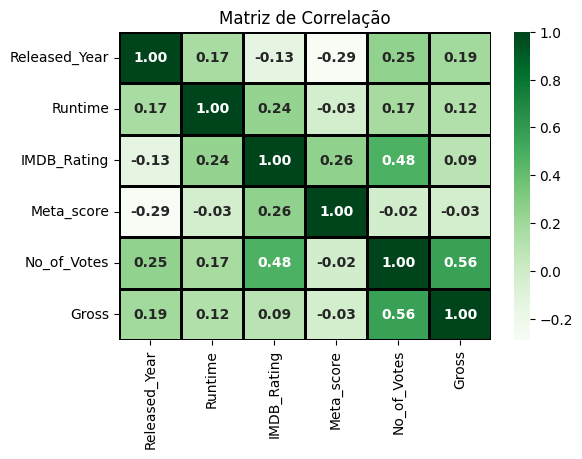

In [5]:
plot_correlation_heatmap(data)

### Análise das Correlações entre as Variáveis Numéricas

- **Número de Votos (No_of_Votes) e Faturamento (Gross)**: Correlação de **0.56**.
  - Existe uma correlação positiva moderada entre o número de votos recebidos por um filme e seu faturamento. Filmes mais populares tendem a ter maior faturamento.

- **IMDB Rating e Número de Votos (No_of_Votes)**: Correlação de **0.48**.
  - Filmes com notas mais altas no IMDB tendem a receber mais votos, indicando uma relação entre qualidade percebida e engajamento dos espectadores.

- **IMDB Rating e Meta Score**: Correlação de **0.26**.
  - Existe uma correlação positiva fraca entre a nota do IMDB e o Meta Score, sugerindo uma associação entre avaliações críticas e públicas.

- **Runtime e IMDB Rating**: Correlação de **0.24**.
  - Filmes mais longos tendem a ter notas ligeiramente mais altas no IMDB, sugerindo que uma narrativa mais desenvolvida pode influenciar positivamente as avaliações.

### Partimos para a análise das variáveis não numéricas e suas relações com as demais, especialmente com o faturamento.

Plotamos a relação entre o faturamento e as variáveis Meta_score e IMDB_Rating. Observamos que a correlação entre essas variáveis foi praticamente zero, o que contraria a expectativa de que filmes aclamados pela crítica e/ou pelo público gerariam maior faturamento.

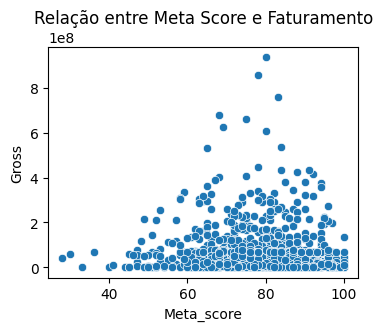

In [6]:
plot_scatter_relation(data, 'Meta_score', 'Gross', 'Relação entre Meta Score e Faturamento')

A relação entre Meta Score e Faturamento existe, porém não é linear, o que resulta em um coeficiente de correlação baixo. Filmes com maior faturamento não são necessariamente os mais bem avaliados pela crítica. No entanto, filmes mal avaliados pela crítica tendem a ter um faturamento menor.

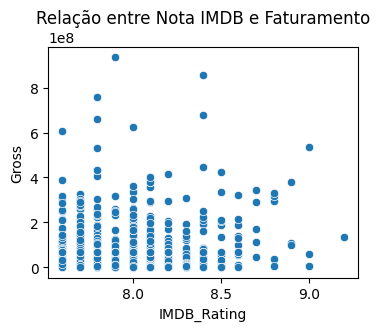

In [7]:
plot_scatter_relation(data, 'IMDB_Rating', 'Gross', 'Relação entre Nota IMDB e Faturamento')

Não foi possível identificar visualmente uma relação consistente entre as variáveis IMDB_Rating e o Faturamento (Gross).

### Analisamos se a classificação etária apresenta relação com o faturamento.

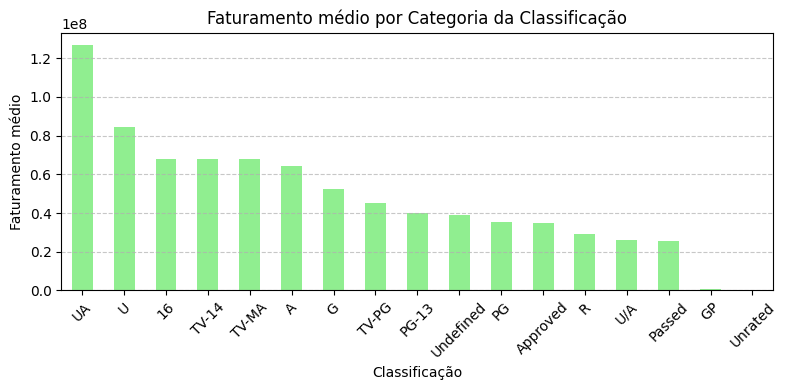

In [8]:
plot_mean_gross_by_certificate(data)

- **UA (Unrestricted Adult)**: Maior gross médio, indicando amplo apelo e alta receita.
- **U (Universal)**: Também possui um gross médio significativo, atraindo um público diversificado.
- **16, TV-14, TV-MA, A**: Gross médios substanciais, indicando potencial para filmes com conteúdo específico.
- **G, TV-PG, PG-13, PG**: Gross médio intermediário, adequado para audiências variadas.
- **R, U/A, Passed, GP, Unrated**: Gross médio menor, devido a restrições de idade e apelos específicos.

fonte:https://en.wikipedia.org/wiki/Motion_picture_content_rating_system

### Analisamos as relações da coluna Gênero com as demais.

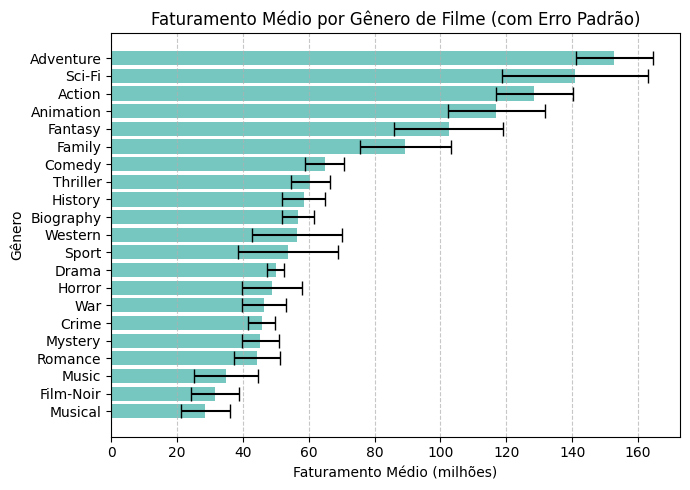

In [9]:
plot_stat_by_genre(data, stat='Gross')

Os filmes de aventura, ficção científica e ação destacam-se com os maiores faturamentos, enquanto os gêneros de romance e musical tendem a apresentar alguns dos menores faturamentos.

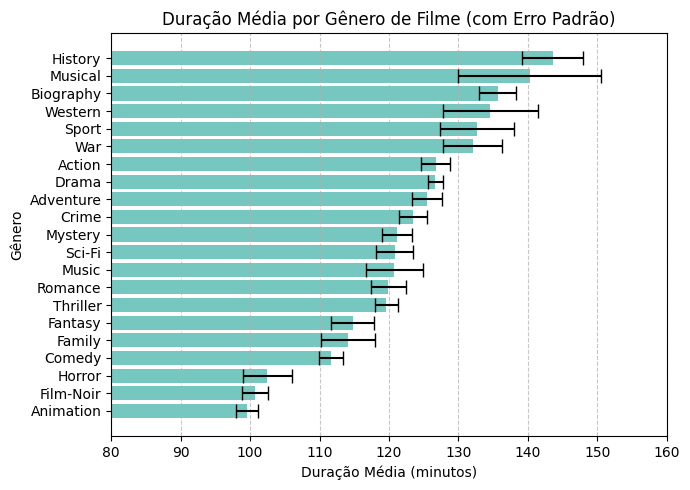

In [10]:
plot_stat_by_genre(data, stat='Runtime')

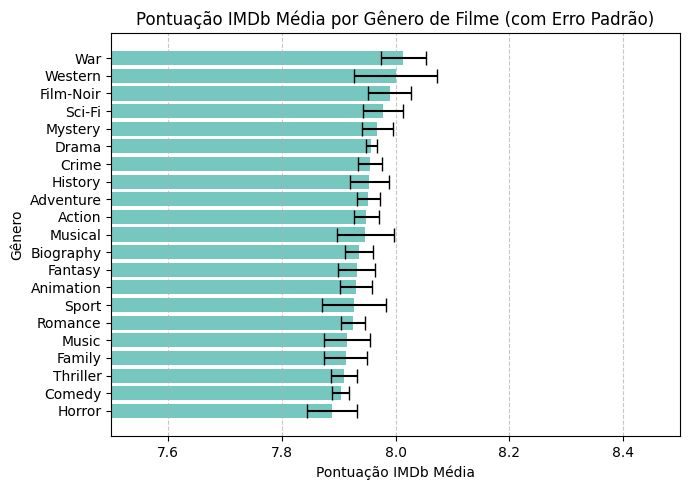

In [11]:
plot_stat_by_genre(data, stat='IMDB_Rating')

No primeiro gráfico, "History" apresenta a maior duração média, seguida por "Musical" e "Biography", enquanto "Animation" tem a menor duração média. No segundo gráfico, "War" lidera com a maior pontuação IMDb média, seguido por "Western" e "Film-Noir", enquanto "Horror" tem a menor pontuação média. A maioria dos gêneros tem durações médias entre 100 e 130 minutos e pontuações médias entre 7.8 e 8.0.

### Agora vamos confirmar se o tempo de duração apresenta relação com o faturamento.

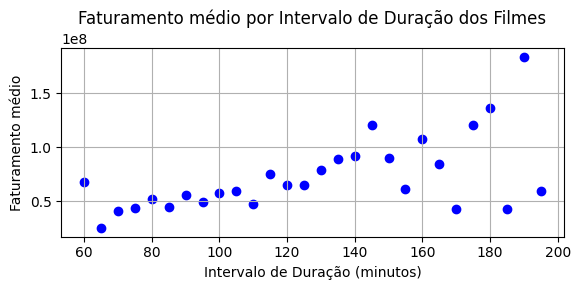

In [12]:
plot_average_gross_by_runtime(data)

Conforme evidenciado pela correlação linear e confirmado pelo gráfico, filmes mais longos tendem a receber avaliações ligeiramente mais altas no IMDB. Isso sugere que uma narrativa mais desenvolvida pode influenciar positivamente a percepção dos espectadores.

### Investigaremos também o faturamento para os diretores e atores, conforme mostrado nos gráficos a seguir dos 10 principais diretores e estrelas por faturamento médio.

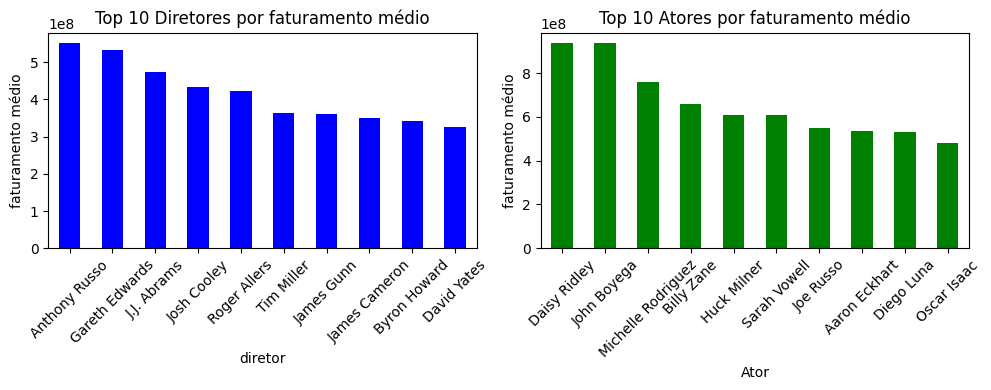

In [13]:
plot_top_directors_and_stars(data)

Notavelmente, alguns atores e diretores estão associados a filmes de maior faturamento. Isso indica influência desses profissionais na atratividade financeira dos filmes em que estão envolvidos, possivelmente refletindo seu apelo junto ao público e sua capacidade de impulsionar o sucesso comercial das produções.

# 2)-
# a.	Qual filme você recomendaria para uma pessoa que você não conhece?

Uma recomendação sólida, com base no dataset, são os filmes classificados como Universal (U) que possuem altos IMDB Ratings e Meta Scores. Filmes com certificação "U" são apropriados para todas as idades, garantindo que sejam adequados para qualquer público.


Com base nesses critérios, **"The Lord of the Rings: The Return of the King"** se destaca como uma excelente escolha.

In [14]:
top_movies_u = top_rated_u_movies(data)
print(top_movies_u.to_string(index=False))

                                     Series_Title  IMDB_Rating  Meta_score  Released_Year Certificate
                                     12 Angry Men          9.0        96.0         1957.0           U
                                  The Dark Knight          9.0        84.0         2008.0          UA
    The Lord of the Rings: The Return of the King          8.9        94.0         2003.0           U
The Lord of the Rings: The Fellowship of the Ring          8.8        92.0         2001.0           U
                                     Forrest Gump          8.8        82.0         1994.0          UA


# b.	Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

Com base na análise exploratória dos dados, os principais fatores que estão relacionados com uma alta expectativa de faturamento de um filme são:

Número de Votos: Existe uma correlação positiva moderada entre o número de votos recebidos por um filme e seu faturamento. **Filmes populares, que geram mais engajamento, atraem mais votos e tendem a ter uma receita maior.**

Gênero do Filme: Gêneros como Aventura, Ficção Científica e Ação têm maior faturamento médio, enquanto outros como Romances e Musicais apresentam menores faturamentos. **Isso sugere que o gênero influencia significativamente a receita do filme.**

Classificação Etária: Filmes classificados como UA (Unrestricted Adult) e U (Universal) têm os maiores valores médios de faturamento. **Isso indica que filmes com apelo amplo, adequados para diferentes faixas etárias, tendem a ter maior receita.**

Duração do Filme: Existe uma tendência onde filmes com duração mais longa têm um faturamento médio um pouco maior. **Isso sugere que uma narrativa bem construida será valorizada pelo público, refletindo-se em uma receita potencialmente maior.**

Análise da crítica especializada: A relação entre Meta Score e Receita Bruta existe, porém não é linear. Portanto, **os valores da crítica especializada devem ser considerados a fim de se evitar a gravação de um filme com baixo retorno financeiro e baixa recepção crítica.**

Atores e Direção: Alguns atores e diretores estão associados a filmes de maior faturamento, o que pode indicar a importância do seu prestígio e habilidade na atração de público. **A reputação e o talento dos atores principais e do diretor podem influenciar significativamente o desempenho financeiro de um filme.**

# c.	Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

#### Na busca por insights, verificamos as palavras com maior porcentagem de ocorrencia no overview de cada gênero.

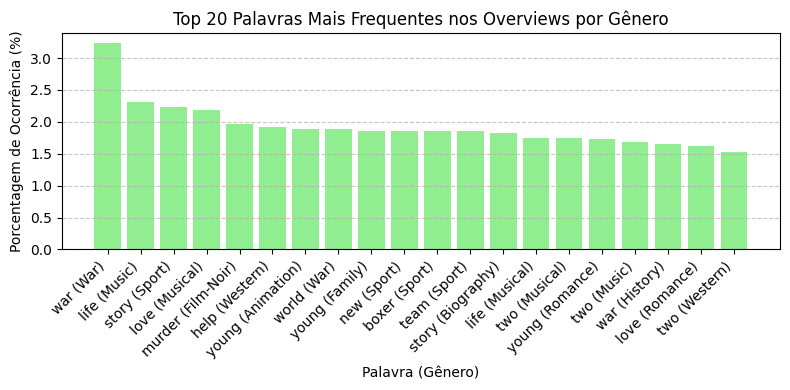

In [15]:
plot_top_words_by_genre(data)

**Gênero: War**
   - "war" (3.23%), seguida por "world" (1.89%).
Demonstra que esse gênero, como o próprio nome sugere, é focado em conflitos bélicos, muitas vezes retratando as guerras mundiais (World War).

**Gênero: Sport**
   - "Story" (2.23%), "new" (1.86%), "boxer" (1.86%), e "team" (1.86%) são as palavras mais representativas.
Indica que filmes de Esporte frequentemente exploram narrativas de superação, novos desafios, boxeadores e equipes esportivas.

**Gênero: Musical**
   - "Love" (2.18%) e "life" (2.05%) são as palavras dominantes.
Reflete que os musicais tendem a focar em histórias que envolvem romance e experiências de vida.

**Gênero: Romance**
   - "Young" (1.74%) e "love" (1.62%) são destacadas.
Indica que filmes de Romance exploram principalmente temas de amor e relacionamentos, muitas vezes envolvendo personagens jovens.

# Hyperlinks

. [Importação das bibliotecas e pacotes](#Importação-das-bibliotecas-e-pacotes)

. [Definição das Funções](#Definição-das-Funções)

. [Análise Exploratória de Dados (EDA)](#Análise-Exploratória-de-Dados-(EDA))

. [Modelagens](#Modelagens)

. [Conclusão](#Conclusão)

# Modelagens

## Para inferir o gênero do filme a partir do overview podemos utilizar um modelo de processamento de linguagem natural pré-treinado e o ajustarmos para nossa tarefa.

Utilizamos o modelo RoBERTa, uma versão robusta do BERT (Bidirectional Encoder Representations from Transformers), que é uma arquitetura de rede neural baseada em Transformers desenvolvida para processamento de linguagem natural. O BERT e o RoBERTa são modelos de aprendizado profundo que capturam o contexto de uma palavra em todas as suas aparições em um texto, permitindo uma compreensão mais profunda e precisa.

O processo envolveu a tokenização dos textos dos resumos dos filmes usando um tokenizer pré-treinado do Hugging Face Transformers, convertendo-os em sequências de tokens com um comprimento máximo pré-definido. Em seguida, transformamos os gêneros dos filmes em um formato binário multirrótulo para classificação multirrótulo, onde cada filme pode pertencer a múltiplos gêneros simultaneamente. Dividimos os dados em conjuntos de treino e teste e tokenizamos os textos desses conjuntos.

Carregamos o modelo RoBERTa pré-treinado e o configuramos para a classificação multirrótulo, treinando-o em várias épocas.

No entanto, enfrentamos desafios devido ao tamanho reduzido do dataset e ao desbalanceamento das classes, o que dificultou o fine-tuning eficiente do modelo pré-treinado.

In [16]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
trained_model, test_dataloader, mlb = train_roberta_model(data, tokenizer, epochs=8)

Tokenizing texts: 100%|██████████| 200/200 [00:00<00:00, 2838.18it/s]


Época 1: Perda média de treinamento: 0.4677989619970322
Época 2: Perda média de treinamento: 0.36459587037563324
Época 3: Perda média de treinamento: 0.32532146096229553
Época 4: Perda média de treinamento: 0.28858744353055954
Época 5: Perda média de treinamento: 0.2577023708820343
Época 6: Perda média de treinamento: 0.23106490641832353
Época 7: Perda média de treinamento: 0.2077252346277237
Época 8: Perda média de treinamento: 0.1855614513158798


In [17]:
evaluate_and_display_results(trained_model, test_dataloader, mlb, num_samples=10)

+---------+-------------------------------------+----------------------------------+
| Amostra |            Rótulos Reais            |        Rótulos Previstos         |
+---------+-------------------------------------+----------------------------------+
|    1    |     ('Drama', 'Romance', 'War')     |    ('Drama', 'Action', 'War')    |
|    2    |         ('Drama', 'Comedy')         |   ('Drama', 'Comedy', 'Crime')   |
|    3    |  ('Drama', 'Thriller', 'Mystery')   |  ('Drama', 'Crime', 'Mystery')   |
|    4    |        ('Drama', 'Romance')         |  ('Drama', 'Comedy', 'Romance')  |
|    5    | ('Drama', 'Adventure', 'Animation') | ('Drama', 'Comedy', 'Adventure') |
|    6    |       ('Drama', 'Biography')        | ('Drama', 'Crime', 'Biography')  |
|    7    |    ('Drama', 'Crime', 'Action')     | ('Drama', 'Adventure', 'Action') |
|    8    |    ('Drama', 'Crime', 'Mystery')    |  ('Drama', 'Crime', 'Mystery')   |
|    9    |    ('Drama', 'Crime', 'Mystery')    |  ('Drama', 'Cri

Observamos pela perda durante o treinamento que o modelo está capturando informações do Overview para distinguir entre os gêneros dos filmes. Dado que o modelo prevê exatamente 3 gêneros para cada filme, enquanto nosso dataset permite até 3 gêneros por filme, desenvolvemos uma métrica de acurácia personalizada. Essa métrica considera a presença dos gêneros reais entre os gêneros previstos.

Essa abordagem avalia cada amostra, contabilizando acertos parciais baseados nos gêneros verdadeiros que estão presentes nos gêneros previstos. Por exemplo, se um filme tem dois gêneros reais e um deles está entre os três gêneros previstos, a amostra é considerada como tendo acertado parcialmente um dos gêneros.

Portanto, ao comparar os rótulos reais com os previstos e analisando a acurácia calculada, podemos concluir que é viável inferir o gênero dos filmes com base nas informações fornecidas nos overviews. Mesmo com um dataset pequeno e desbalanceado, o modelo pré-treinado demonstrou ser adaptável ao nosso problema, exibindo um desempenho satisfatório na tarefa de inferência de gêneros a partir dos overviews.

# 3)
### Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Para prever a nota do IMDb a partir dos dados fornecidos, inicialmente carregamos o dataset e identificamos a variável alvo, que é o IMDB_Rating. Realizamos o preprocessamento das variáveis, incluindo transformações como conversão de tipos de dados para numéricos, tratamento de valores faltantes e codificação de variáveis categóricas, como o gênero do filme.

**O problema que estamos resolvendo é de regressão**, onde tentamos prever um valor contínuo (a nota do IMDb) com base em várias características dos filmes.

Utilizamos três modelos diferentes para previsão: Random Forest, Regressão Linear e XGBoost. Cada um desses modelos possui características distintas que influenciam sua capacidade de ajuste aos dados e interpretabilidade.

Para avaliar a performance desses modelos, utilizamos três métricas:

**MSE** (Erro Quadrático Médio): Mede o quão próximas as previsões estão dos valores reais, penalizando erros grandes. Valores menores indicam melhor performance.

**MAE** (Erro Médio Absoluto): Calcula a média dos valores absolutos dos erros entre previsões e valores reais. É menos sensível a outliers em comparação com o MSE.

**R²** (Coeficiente de Determinação): Indica a proporção da variância na variável dependente (IMDB_Rating) que é previsível a partir das variáveis independentes utilizadas no modelo. Valores mais próximos de 1 indicam um modelo que explica bem a variabilidade dos dados.

In [18]:
best_model, best_results, best_feature_importances, best_pipeline, best_mlb, best_feature_names = train_and_evaluate_models(data)

{'Model': 'Random Forest', 'MSE': 0.037523405000000024, 'MAE': 0.14987500000000026, 'R²': 0.42838027847175664}
{'Model': 'Linear Regression', 'MSE': 0.043694554317350816, 'MAE': 0.16625409884909068, 'R²': 0.3343709353885991}
{'Model': 'XGBoost', 'MSE': 0.04165113755618812, 'MAE': 0.1546935987472534, 'R²': 0.36549970208719607}


Com base nos resultados obtidos:

O modelo Random Forest demonstrou o menor MSE (0.037), o menor MAE (0.149) e o maior R² (0.4283), destacando-se como a escolha preferencial. Embora seja possível realizar uma busca por melhores hiperparâmetros ou combinar diferentes modelos para aumentar a robustez, priorizaremos a análise das características envolvidas na predição em vez de focar exclusivamente na redução dos erros.

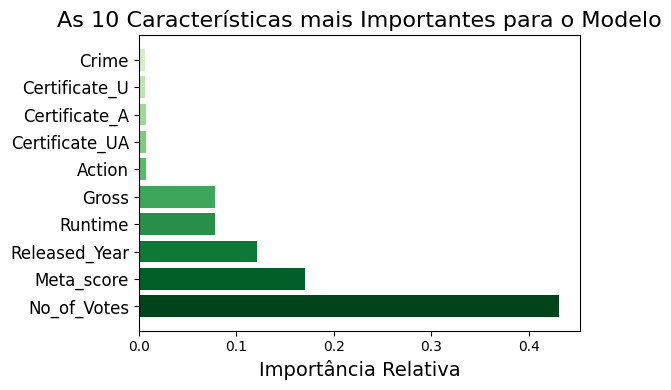

In [19]:
plot_feature_importances(best_feature_importances, best_feature_names, top_n=10)

O gráfico de importância das características do modelo de Random Forest indica o impacto de cada variável na previsão da nota do IMDB.

1. **No_of_Votes**:
   - Esta característica foi a mais importante para o modelo, o que é consistente com o coeficiente de correlação previamente calculado.

2. **Meta_score**:
   - A pontuação do Meta Score também se destacou como uma característica significativa, indicando que as avaliações críticas têm influência na nota do IMDB.

3. **Released_Year**:
   - O ano de lançamento do filme mostrou ser uma característica importante, possivelmente refletindo tendências ao longo do tempo na forma como os filmes são avaliados pelos usuários do IMDB.

4. **Runtime**:
   - A duração do filme teve um impacto moderado na previsão da nota, sugerindo que, conforme já demonstrado anteriormente, filmes de determinadas durações são costumeiramente mais bem avaliados. 

5. **Gross**:
   - O faturamento também foi uma característica significativa, mesmo não possuindo, conforme exposto na EDA, correlação linear ou relação visualmente detectável com a nota do IMDB.

6. **Certificate**:
   - As categorias de certificação (classificação indicativa) mostraram alguma importância, mas com variações entre as diferentes classificações. Certificados como "UA", "A" e "U" tiveram algum impacto na previsão da nota do IMDB.

7. **Gêneros (Genres)**:
   - Os gêneros dos filmes também mostraram-se importantes para o modelo, com destaque para o gênero "Ação".

In [20]:
save_model_files(best_pipeline, best_mlb, best_model)

Modelo, pipeline e MultiLabelBinarizer salvos com sucesso.


#  4)
### Supondo um filme com as seguintes características:

In [21]:
new_movie = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

### Qual seria a nota do IMDB?

In [22]:
predicted_rating = predict_imdb_rating(new_movie)

A nota prevista do IMDb para 'The Shawshank Redemption' é: [8.769]


Embora 'The Shawshank Redemption' detenha a mais alta classificação de todos os tempos no IMDb (9.3), o que dificulta a precisão absoluta, nosso modelo conseguiu identificar padrões suficientes nas características para reconhecer que este filme é amplamente aclamado.

# Conclusão

Em suma, a PProductions deve investir em um filme de aventura, ficção científica ou ação, com uma narrativa bem desenvolvida e uma classificação etária ampla. O filme deve contar com a participação de atores e diretores renomados para maximizar seu apelo comercial e potencial de faturamento. Essas recomendações são fundamentadas nos dados, que indicam uma alta expectativa de receita, maior engajamento do público e uma recepção positiva tanto do público quanto da crítica.